# Label Frames & Train Frame Classifier

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook allows you to label the individual frames in a video from which a classifier in the sklearn library can be trained.

Notebook exports: labelled frames in a csv file and a trained model in a joblib file.

## TOC:
0. [Import Libraries & Setup Helper Functions](#0.-Import-Libraries-&-Setup)
1. [Labeller](#1.-Detect-Pose-&-Label)
2. [Train & Evaluate Models](#2.-Train-&-Evaluate-Models)

# 0. Import Libraries & Setup

In [18]:
folder_name = 'overhead-press-videos'
output_input_csv_filename = 'overhead-press-labelled-frames.csv'

In [66]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier

import pickle
from joblib import dump, load

import cv2
import mediapipe as mp

import os

In [20]:
all_landmarks = [] # List of dictionaries storing all the landmarks

def label_landmarks(landmarks, label):
    unboxed_landmarks = {}
    unboxed_landmarks['label'] = label # Label of the keypoint's coordinates
    
    # Store all the keypoint's x0,y0,z0...z32 coordinates in dictionary
    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append(unboxed_landmarks)

# 1. Detect Pose & Label

The code below is used to label frames in all the videos in a folder. First we find the training set and set aside the test set in the evaluation.

- Press 'b' to label a frame as having too much of a bend in the back
- Press 'f' to label a frame as moving the bar too far forwards
- Press 'g' to label a frame as being good
- Press 'k' to label a frame as having too much of a bend in the knees

In [21]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

all_videos = []

directory = os.fsencode(folder_name)

for file in os.listdir(directory):
    all_videos.append(os.fsdecode(file))
    
# Filenames of the videos we want to train the frame labeller on
# The test set is in f1-gen-heuristic notebook, same seed is used so same train and test set is created
train_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)

exit = False

for filename in train_videos:
    cap = cv2.VideoCapture(folder_name + '/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            cv2.rectangle(image, (0,0), (225, 100), (0,0,0), -1)

            k = cv2.waitKey(1)
            # Press 'b' to label frame as back
            if k == 98:
                label_landmarks(results.pose_landmarks, 'back')
                cv2.putText(image, 'back', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

            # Press 'f' to label frame as forward
            if k == 102:
                label_landmarks(results.pose_landmarks, 'forward')
                cv2.putText(image, 'forward', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

            # Press 'g' to label frame as good
            if k == 103:
                label_landmarks(results.pose_landmarks, 'good')
                cv2.putText(image, 'good', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
                
            # Press 'k' to label frame as knee
            if k == 107:
                label_landmarks(results.pose_landmarks, 'knees')
                cv2.putText(image, 'knees', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
                
            # Press ESC to quit
            if k == 27:
                exit = True
                break

            cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
            cv2.imshow("output", image)

        cap.release()
        cv2.destroyAllWindows()
        if exit == True:
            break

In [23]:
# Save the data in a csv
landmarks_df = pd.DataFrame(all_landmarks)
landmarks_df.to_csv(output_input_csv_filename, index=False)

In [100]:
# Read the data from a csv
landmarks_df = pd.read_csv(output_input_csv_filename)
landmarks_df

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,good,0.377190,0.351066,-0.063103,0.386585,0.337982,-0.100796,0.390442,0.337149,-0.100853,...,-0.134606,0.536909,0.854522,0.377173,0.394010,0.894329,-0.309916,0.434117,0.852061,0.294573
1,good,0.398532,0.347942,-0.121728,0.410827,0.334926,-0.152977,0.415327,0.334304,-0.152988,...,-0.072586,0.534788,0.852542,0.454918,0.397052,0.899195,-0.269252,0.431020,0.852731,0.369086
2,good,0.420794,0.344876,-0.076811,0.436795,0.331356,-0.112735,0.441375,0.331162,-0.112752,...,-0.078055,0.531940,0.864624,0.359390,0.402668,0.903814,-0.267744,0.428264,0.865900,0.256004
3,good,0.434423,0.348592,-0.047648,0.448825,0.337345,-0.085227,0.453628,0.337473,-0.085271,...,-0.146864,0.525566,0.864103,0.323644,0.406719,0.902248,-0.340423,0.417343,0.864937,0.219146
4,good,0.445272,0.340828,-0.113242,0.459366,0.330230,-0.155790,0.463526,0.330359,-0.155822,...,-0.045799,0.525503,0.863961,0.396571,0.402695,0.903880,-0.231831,0.412960,0.862492,0.300305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,back,0.512436,0.344566,-0.052725,0.529329,0.330708,-0.085722,0.533276,0.330762,-0.085792,...,-0.108403,0.558312,0.859814,0.309405,0.444578,0.895718,-0.315301,0.446250,0.860600,0.177396
197,back,0.547150,0.346205,-0.009631,0.563841,0.333737,-0.047201,0.567452,0.333611,-0.047243,...,-0.174935,0.558525,0.859593,0.216647,0.439632,0.896894,-0.352055,0.461504,0.884640,0.098900
198,knees,0.468252,0.420763,-0.125757,0.485559,0.411474,-0.174012,0.488858,0.412104,-0.174063,...,-0.244412,0.620362,0.901184,0.474206,0.473071,0.938734,-0.258542,0.500941,0.914785,0.486686
199,knees,0.524308,0.410642,-0.082927,0.543093,0.403821,-0.125843,0.546874,0.404983,-0.125928,...,-0.254134,0.600749,0.903888,0.485892,0.477649,0.943188,-0.287961,0.501588,0.914757,0.497618


# 2. Train & Evaluate Models

In [101]:
model_scores = [] # Used for comparing different model's scores

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                   'Accuracy': acc, 
                   'Precision': precision, 
                   'Recall': recall,
                   'F1 Score': f1}

    if display_matrix:
        labels= ['forward', 'back', 'knees', 'good']
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()
    
    return model_metrics

## Feature Extraction
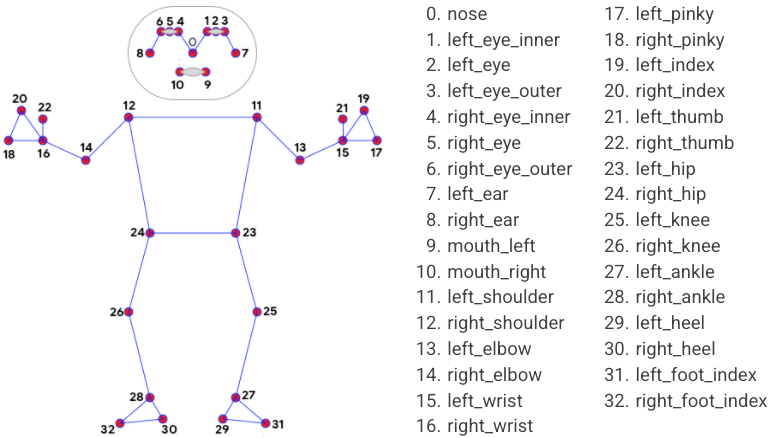

In [102]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [103]:
landmarks_df['bicep_angle'] = landmarks_df.apply(lambda row: get_angle(row, 11, 13, 15), axis=1)
landmarks_df['hip_angle'] = landmarks_df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
landmarks_df['knee_angle'] = landmarks_df.apply(lambda row: get_angle(row, 23, 25, 27), axis=1)
landmarks_df['foot_angle'] = landmarks_df.apply(lambda row: get_angle(row, 25, 27, 31), axis=1)
landmarks_df['elbow_hip_angle'] = landmarks_df.apply(lambda row: get_angle(row, 13, 11, 23), axis=1)

In [104]:
landmarks_df = landmarks_df.filter(['hip_angle', 'bicep_angle', 'knee_angle', 'foot_angle', 'elbow_hip_angle', 'label'])

# Setup the testing and training sets
X = landmarks_df.drop('label', axis=1)
y = landmarks_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(134, 5) (134,) (67, 5) (67,)


## Models

### Linear SVC

C:\Users\abid5.000\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


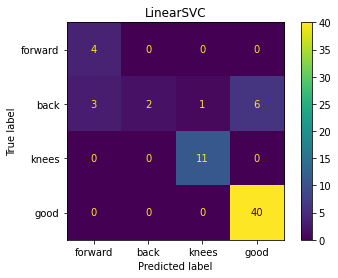

{'Classifier': 'LinearSVC', 'Accuracy': 0.8507462686567164, 'Precision': 0.8394151138716356, 'Recall': 0.7916666666666667, 'F1 Score': 0.8507462686567164}


In [105]:
svc_model = LinearSVC(random_state=1).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

scores = evaluate_model('LinearSVC', y_pred, True)
model_scores.append(scores)
print(scores)

The model works pretty well without any feature extraction.

In [106]:
dump(svc_model, 'svc-overhead-press-mistakes.joblib') # Export model

['svc-overhead-press-mistakes.joblib']

### Nearest Neighbours

In [107]:
# Find K value with lowest error
error_rate = []
for i in range(1,35):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

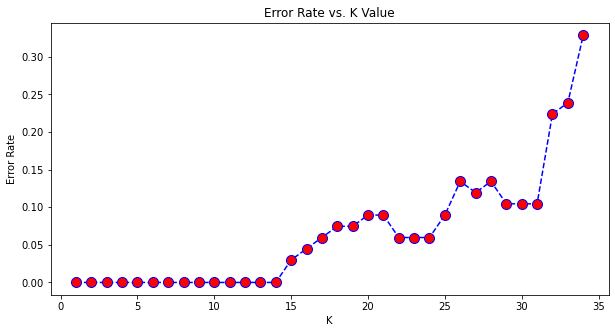

In [108]:
plt.figure(figsize=(10,5))
plt.plot(range(1,35),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

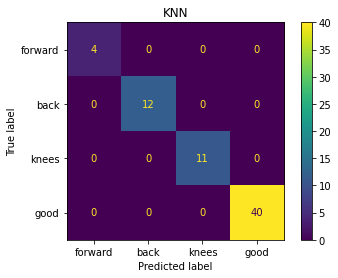

{'Classifier': 'KNN', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [109]:
knc_model = KNeighborsClassifier(5).fit(X_train, y_train)
y_pred = knc_model.predict(X_test)
scores = evaluate_model('KNN', y_pred, True)
model_scores.append(scores)
print(scores)

In [110]:
dump(knc_model, 'knc-overhead-press-mistakes.joblib') # Export model

['knc-overhead-press-mistakes.joblib']

### Neural Network

C:\Users\abid5.000\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


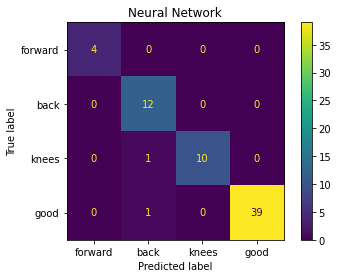

{'Classifier': 'Neural Network', 'Accuracy': 0.9701492537313433, 'Precision': 0.9642857142857143, 'Recall': 0.9710227272727273, 'F1 Score': 0.9701492537313433}


In [111]:
mlp_clf = MLPClassifier(activation='relu',
                        learning_rate='adaptive',
                        hidden_layer_sizes=(100),
                        learning_rate_init=0.01,
                        random_state=1)

mlp_model = mlp_clf.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
scores = evaluate_model('Neural Network', y_pred, True)
model_scores.append(scores)
print(scores)

In [112]:
dump(mlp_model, 'mlp-overhead-press-mistakes.joblib') # Export model

['mlp-overhead-press-mistakes.joblib']

### Naive Bayes

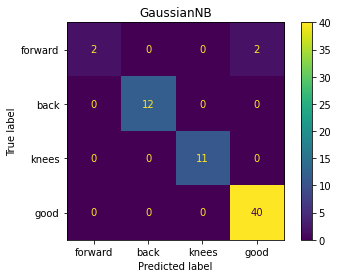

{'Classifier': 'GaussianNB', 'Accuracy': 0.9701492537313433, 'Precision': 0.9880952380952381, 'Recall': 0.875, 'F1 Score': 0.9701492537313433}


In [113]:
gnb_model = GaussianNB()
y_pred = gnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('GaussianNB', y_pred, True)
model_scores.append(scores)
print(scores)

In [114]:
dump(gnb_model, 'gnb-overhead-press-mistakes.joblib') # Export model

['gnb-overhead-press-mistakes.joblib']

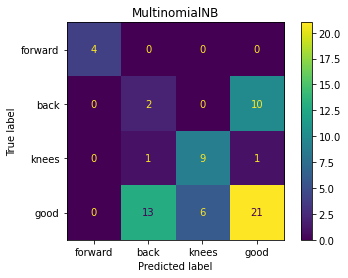

{'Classifier': 'MultinomialNB', 'Accuracy': 0.5373134328358209, 'Precision': 0.5953125, 'Recall': 0.6274621212121213, 'F1 Score': 0.5373134328358209}


In [115]:
mnb_model = MultinomialNB()
y_pred = mnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('MultinomialNB', y_pred, True)
model_scores.append(scores)
print(scores)

## Best Performers

In [116]:
eval_scores = pd.DataFrame(model_scores)
eval_scores = eval_scores.sort_values(by = ['F1 Score'], ascending = False)
eval_scores

,Classifier,Accuracy,Precision,Recall,F1 Score
1,KNN,1.000000,1.000000,1.000000,1.000000
2,Neural Network,0.970149,0.964286,0.971023,0.970149
3,GaussianNB,0.970149,0.988095,0.875000,0.970149
0,LinearSVC,0.850746,0.839415,0.791667,0.850746
4,MultinomialNB,0.537313,0.595313,0.627462,0.537313


All classifiers perform strongly. See how the classifiers perform on all the videos. See f1-gen-frame for results.